# Cog detection

The image processing-based gear teeth (cog) counter is a task implemented with OpenCV following this steps:
1. Detect gear by segmenting the image.
2. Detect the inner circle by morphological opening region.
3. Obtain cog pixels by subtracting inner circle of the segmented image.
4. Detect cogs by finding connected components.


<h1><center> 

Example image<br>
![picture](https://drive.google.com/uc?id=1wQ2S4y4PlHzUW6QUAW34t0ccsddvUEPk)

</center></h1>

This approach is based on ["Image Analysis Techniques for Industrial Systems"](https://drive.google.com/file/d/1mID6vNbdMQCI2RRHZVWfSckLI7-ZzLK6/view) (page 29).

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def imshow(img):
  """
        Prepares image plot in google colab with pyplot.
        Parameters:
        -----------
            img : np.array,
                  image to be shown.
  """
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis("off")

In [ ]:
# Image file name
img_path = "imagem3.jpg"
img = cv2.imread(img_path)

## Image segmentation

The gear pixels in the image are obtained by image segmentation. This step is useful for separating the object from the background. A simple segmentation method is binarization.

### Binarization

Binarization requires a grayscale input image, then it converts the highest valued pixels to white (255) and the lowest to black (0), in relation to a threshold. The stipulation of this threshold takes place automatically with Otsu's method.

In [ ]:
# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Filter out remaining pixels
gray = cv2.medianBlur(gray, 5)

# Binarize grayscale image with Otsu's method for automatic image thresholding
(thres, bw) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

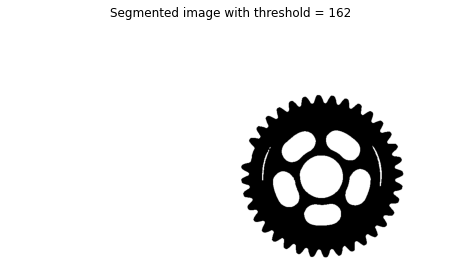

In [ ]:
# Display segmented image
plt.figure(figsize = (8, 8))
imshow(bw)
plt.title(f"Segmented image with threshold = {int(thres)}")
plt.show()

### Filling holes

Segmentation allows the gear pixels detection, but it is still possible to fill in the remaining holes and noises. This process consists of the following steps:
1. Detect the holes by flood filling the background of the binary image, i.e. only the holes are white (255).
2. Invert flooded image to match the binary gear image.
3. Fill the holes by adding the inverse flooded image to the binary image.

In [ ]:
floodfill = bw.copy()

# Mask used to flood filling
# Its sizes must be 2 pixels larger than the image
h, w = bw.shape[:2]
mask = np.zeros((h + 2, w + 2), np.uint8)

# Flood fill from point (0, 0), i.e. background
cv2.floodFill(floodfill, mask, (0,0), 0);

# Invert flood filled image
floodfill_inv = cv2.bitwise_not(floodfill)

# Combine the two images to get the foreground.
fill = bw & floodfill_inv

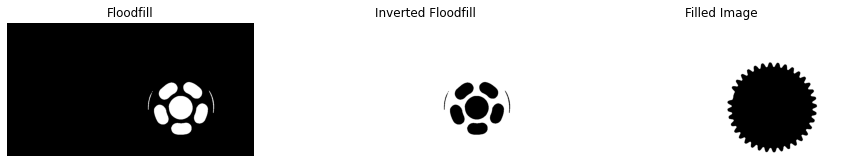

In [ ]:
# Display images
plt.figure(figsize = (15, 12))

ax = plt.subplot(1, 3, 1)
imshow(floodfill)
plt.title("Floodfill")

ax = plt.subplot(1, 3, 2)
imshow(floodfill_inv)
plt.title("Inverted Floodfill")

ax = plt.subplot(1, 3, 3)
imshow(fill)
plt.title("Filled Image")

plt.show()

## Cog partitioning

With the gear pixels already detected and preprocessed, the cogs can be found by separating the teeth from the inner circle. One technique to obtain the inner circle is the morphological opening. Once the inner circle is obtained, subtracting it from the segmented image guarantees the detection of the cog pixels.

### Image Opening

The opening operator erodes a region and then dilates the result, removing isolated pixels and small branches. To get the inner circle, it is important to select a kernel larger than the teeth and not far from the inner circle size, so that only the cog pixels are eliminated during erosion.


In [ ]:
# Invert image colors for opening to work
fill = cv2.bitwise_not(fill)
# Kernel size is (100. 100), determined empirically
kernel = cv2.getStructuringElement(shape = cv2.MORPH_ELLIPSE, ksize = (100,100))
# Open region
open = cv2.morphologyEx(fill, cv2.MORPH_OPEN, kernel)

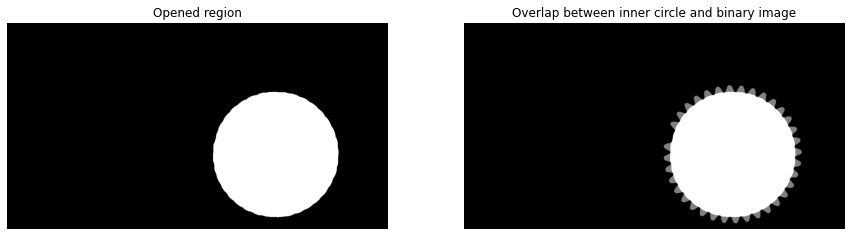

In [ ]:
# Display images
plt.figure(figsize = (15, 12))
plt.subplot(1, 2, 1)
imshow(open)
plt.title("Opened region")

plt.subplot(1, 2, 2)
overlap = cv2.addWeighted(fill, 0.5, open, 0.5, 0.0)
imshow(overlap)
plt.title("Overlap between inner circle and binary image")
plt.show()

### Image subtraction

The cogs are obtained by subtracting the inner circle from the binary image. As the relevant pixels of the binary image are black (0), the subtraction operator is `bitwise OR`.

In [ ]:
# Cogs segmented
img_cogs = open | bw

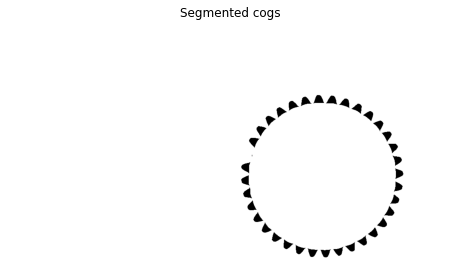

In [ ]:
# Display segmented cogs
plt.figure(figsize = (8, 8))
imshow(img_cogs)
plt.title("Segmented cogs")
plt.show()

## Detect and count cogs

With the cog pixels segmented in a binary image, each cog can be considered a connected component (with 4-pixel connectivity). From this statement, one can use the OpenCV function `connectedComponentsWithStats(image)`, which receives the segmented image and returns the statistics about the connected components found.

In [ ]:
# Invert image colors for conected component detection to work
img_cogs = cv2.bitwise_not(img_cogs)
# Detect connected components
count, labels, stats, centroids = cv2.connectedComponentsWithStats(img_cogs)
# List containing the area of each connected component found
areas = stats[:,4]
# Median of areas, considering there are more cogs than defects (missing cogs)
median = np.median(areas)

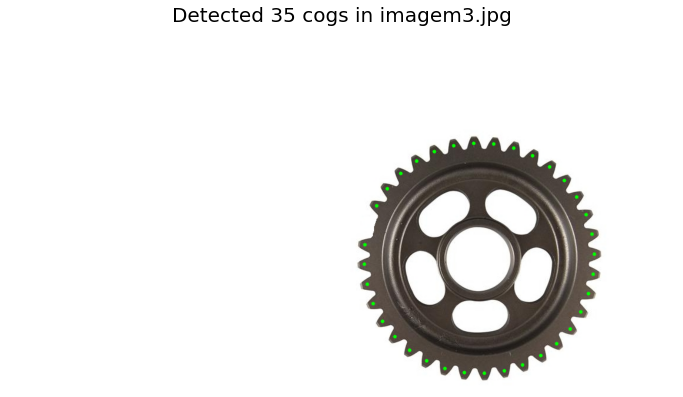

In [ ]:
# Show detected cogs
img_centroids = img.copy()
cog_count = 0
for i in range(0, count):
  # Filter the correct area
  if areas[i] > median - 100 and areas[i] < median + 100:
    cv2.circle(img_centroids, (int(centroids[i,0]), int(centroids[i,1])), 0, (0, 255, 0), 5)
    cog_count += 1

plt.figure(figsize = (12, 12))  
imshow(img_centroids)
plt.title(f"Detected {cog_count} cogs in {img_path}",  fontsize = 20)
plt.show()